In [6]:
import numpy as np  
import numpy.random as random  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

%matplotlib inline

# Simulated Annealing: A Combinatorics Optimisation Solution to the Travelling Salesperson Problem.

###### Author: Aubrey Clark

The focus of this report will be on deploying simulated annealing to find an optimal path connecting 30 US cities in the Travelling Saleperson Problem. The results of which yielded a shortest path connecting 30 US cities of 2176 units. This will then be scaled and benchmarked against higher order problems including Eli51 and Pr76.


# Introduction 

Since the beginning of computational science, the problems contained within have become increasingly large and complicated. This, in part is proportional to the capability of modern day computers, but also due to the rate at which smaller problems are being solved. Despite this, a few old cornerstones of computational fields remain poignant even today. 

Quite obviously, automatic computation allows us to compute large numbers, and because of this one might think that when it comes to problems which deal with an inherently large amount of combinations, computational ability makes them easy. These problems often can fall under combinatorial optimisation problems, and one in particular is the Travelling Salesperson Problem. This problem has thought to have been around since 1930, where it was originally considered to be solvable by brute force. However, such a task would take a standard high end desktop ~ 1e+16 years to find the best solution for a problem containing 30 choices by brute force method. This is inefficient to say the least, and a better solution needs to found.

In this report, a step-by-step approach will be taken to problem-solving. The problem will be broken down into its elementary components, understanding each piece individually. Then, put back together to solve the original problem and even explore more complex variations.

One of the main focusses is on building the infrastructure for simulated annealing. Doing this, I will attempt to find the shortest path connecting 30 cities across the US.

Additionally, optimal routes satisfying different objectives connecting cities were found, including regional cost functions, as-well as inversing selection criteria. Despite this, exploration was done into improving the temperature schedule and pairwise swap capabilities of the simulated annealing, all in an effort to converge to a higher quality solution faster. 

In [7]:
import sys
import matplotlib 
print("Python version: {}".format(sys.version))
print("Matplotlib version: {}".format(matplotlib.__version__))

Python version: 3.10.9 (main, Mar  1 2023, 12:33:47) [Clang 14.0.6 ]
Matplotlib version: 3.7.0


This problem has real world applications; to name a few include delivery service cost reduction, protein folding and alzheimer research. At its essence, the processes behind the solution to this problem have multifaceted applications and generally fall under a class of algorithms called 'continuous optimization' algorithms. 

### Overview

The connection of n points by straight lines will be scrutinised based on its length, then the order of their connection will be changed, judged and accepted or rejected. A stochastic approach was used to ensure equal types of behaviours are used throughout. This idea was then scaled to m connected points.

## I. Building Utility Functions.

First a few utility functions were defined, these underpin the computation in succeeding functions. 

In [8]:
def coord(path):  #Strips the city name from a singular tuple of city name and its x-y co-ordinates.
    
        _, coord = path
        return coord

def coords(path): #Strips city name, and returns list of tuples made only of xy co-ordinate pairs, for a whole list of city co-ordinate tuples.
        _, coords = zip(*path)
        return coords
    
def show_path(path_, starting_city, w=35, h=15): #Takes a list of x-y co-ordniate tuples, and overlays them on a map of the US - connected by straight lines.
    path=coords(path_) 
    x, y = list(zip(*path))
    
    _, (x0, y0) = starting_city
    
    plt.imshow(map)
    plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

Before constructing the additional functions, sample data needed to be loaded and data for 30 US cities was imported, aswell as additional materials including a map.

In [9]:
import json
import copy 
map = mpimg.imread("map.png")  

# List of 30 US state capitals and corresponding coordinates on the map
with open('capitals.json', 'r') as capitals_file:
    capitals = json.load(capitals_file)
    
    
capitals_list = list(capitals.items())

capitals_list = [(c[0], tuple(c[1])) for c in capitals_list] #Is a list of tuples, where the first element is the city name, and the 2nd is a tuple of that cities x-y co-ordinates


The mechanisms that will generate paths, interact with them and calculate their total length were then built.

A random path, for which will be fed into the eventual annealing algorithm was constructed using NumPy's random module. This was done by first generating a random list of integers, the same length or our target path, then using these numbers an index, used a for loop to iterate over this set of random numbers appending the corresponding capital in capitals list using them as an index.

In [10]:
#A general function, that for a given N number of cities generates a random list of them. 

def random_path(N, cities = 30):  #Additional default 'cities' arguement allows for different sized samples of cities.

    sequence = np.random.choice(range(0,cities), N, replace = False) #Generates a list of N random integers between 0 and 'cities' inclusive with no repeats.
    path = []
    
    for k in sequence:
        path.append(capitals_list[k])

    return path

Next, the motor behind the whole optimisation process was made. The swap function took the output from the aforementioned random path function, then created two place-holder variables to store 1 random number each. These random numbers had to be between 0 and the n - 1, where the path has n cities. These indicies and their corresponding city within the path list were then alternatively made equal. This swapped the 2 cities within the path list and then output the this new path list.

In [11]:
#Pairwise swap function, that swaps the order of 2 cities with each other.

def swap(path):
    
    clone = path.copy()
    index1, index2 = np.random.choice(range(0, len(path)),2, replace = False) #replace = false ensures no repeats.
    clone[index2] , clone[index1] = path[index1] , path[index2]

    return clone

The last of the required utility functions for simulated annealing was a function that simply connected the given path as a loop making the first city also the last, then calculated its total length. The function used pythagorean lengths between 2 consecutive cities for each pair of consecutive cities until the end of the list and outputted the total path length of the inputted path. 

In [12]:
#Function that returns the overall length of connecting each city assuming straight lines - using Pythagoras. 

def length_finder(path):

    consecutives = list(zip(path, path[1:])) #Connecting consecutive cities in tuples
    consecutives.append((consecutives[-1][1],consecutives[0][0])) #Connecting final city to initial city (making len(consecutives) = len(path)+1)
    
    distance = 0
    for i in range(len(consecutives)):
        P, Q = coords(consecutives[i]) # Dissecting x and y co-ordinates for two points.

        distance += np.sqrt( (Q[0] - P[0])**2 + (Q[1] - P[1])**2  )

        
    return distance 

After creating the underlying utilities and processes that allowed our algorithm the power to percieve and change given paths. Some schedule was assumed, where at different times our model will behave differently. To do this, the physical phenomenon known as annealing was used - where the algorithm will be malleable to change when at a time where it is 'hot' and less likely to bend it's objective at 'cooler' times.

The temperature schedule used throughout the investigation was:

$$T(t) = \alpha^t T_0$$

In [13]:
#decaying function of temperature with time

def temperature(time, alpha = 0.97, T_0 = 1e+3):
    
    T = (alpha**time)*T_0
    
    return T

## II. Simulated Annealing and Parameter Tuning.

Now we had the infastructure that supports our simulated annealing process. We tied them together in a single function that would; Take a path, determine whether it will accept a newer path, and output a minimised total path length together with the exact order of cities to do so. Crucially, at each step a probability is calculated, this value is dependent on the new and old path length as-well as current temperature.

$$ P = e^{ - \left( d_{new} - d_{old}  \right) / T } $$


The probability is greater than 1 when the new path length is less than the old, in this case it will always be true that a random number between 0-1 will be smaller than the probability, thus the step is accepted. Of course, introducing a temperature schedule adds the additional possibility that if the new path is longer than the old, there is a chance, proportional to temperature that for that this step is infact accepted. This is crucial in promoting an exploratory stage of the algorithm and stops it becoming greedy too soon. We also introduced a time step variable (dt) to vary sensitivity of our algorithm to the cooling schedule.

In [14]:
def annealing(path, T_0 = 1e+3, alpha = 0.97, time = 200, dt = 1): 
    
    
    old_distance, T = length_finder(path), T_0 #Initial values
    
    #Required data structures and variables for plotting purposes.
    N = int(time/dt)     #No. of time steps for a given time period.
    times = np.arange(0,time,dt)        #Array storing each time step
    solution_space = np.zeros(N) ; solution_space[0] = old_distance   #Array to track evolution of the minimum tour distance.
    cooling_schedule = [temperature(time, alpha, T_0) for time in times]    #Entire cooling schedule, for each time step.
    
    for k in range(N):
        
        new_path = swap(path) 
        new_distance = length_finder(new_path)
        
        
        P = np.exp(-(new_distance - old_distance) / T)  #Probability based on new and old path length
        
        if P >= np.random.random(): #If probability is greater than a random number between 0-1.
            
            path , T, old_distance, solution_space[k] = new_path, temperature(times[k], alpha , T_0), new_distance, new_distance
            
        else: T, solution_space[k] = temperature(times[k], alpha, T_0), old_distance
            
            
            
            
    return old_distance, path, solution_space, cooling_schedule
          

Our annealing algorthm needed to be fine tuned, and its parameter values scrutinized. We did this by first tackling a smaller problem, considering 20 cities, and finding their optimum path. 
Of course this had unique problems of its own, but could be bypassed easily. Firstly, given the whole sample is of 30 cities, we had to be careful to use the same initial selection of cities when iterating our algorithm. This cut out any uneeded variation in results dependent on initial path selection, especially when our final solution for 30 cities will not be effected by this.

Our approach also allowed us greater flexibility and capacity for more simulations as 20 city calculations required much less computational power than for 30.

In [15]:
fixed_first_path = [('Richmond', (673.2, 293.6)),
 ('Des Moines', (447.6, 246.0)),
 ('Harrisburg', (670.8, 244.0)),
 ('Salem', (80.0, 139.2)),
 ('Lansing', (563.6, 216.4)),
 ('Columbus', (590.8, 263.2)),
 ('Indianapolis', (548.0, 272.8)),
 ('Atlanta', (585.6, 376.8)),
 ('Providence', (735.2, 201.2)),
 ('Denver', (293.6, 274.0)),
 ('Saint Paul', (451.6, 186.0)),
 ('Little Rock', (469.2, 367.2)),
 ('Albany', (702.0, 193.6)),
 ('Jackson', (501.6, 409.6)),
 ('Boston', (738.4, 190.8)),
 ('Salt Lake City', (204.0, 243.2)),
 ('Madison', (500.8, 217.6)),
 ('Oklahoma City', (392.8, 356.4)),
 ('Raleigh', (662.0, 328.8)),
 ('Columbia', (632.4, 364.8))]  #Arbitary Inital Path, that won't change each time we run the annealing algorithm

In the code below an overflow error will appear. This is due to the extreme case of both parameters $\alpha$ and T$_0$ being small. Since time is fixed in our testing of these parameters, compared to other parameter pair iterations in the annealing process, the temperature at the end of the annealing process will be extremely low. As a consequence, the exponential term becomes significantly large. However, it is important to note that the resulting value is automatically truncated, ensuring that it does not impede the execution of the code.

/var/folders/k_/v2c53s_57fzdvynwxjpvjm0m0000gn/T/ipykernel_11636/1230520231.py:18: RuntimeWarning: overflow encountered in exp
  P = np.exp(-(new_distance - old_distance) / T)  #Probability based on new and old path length


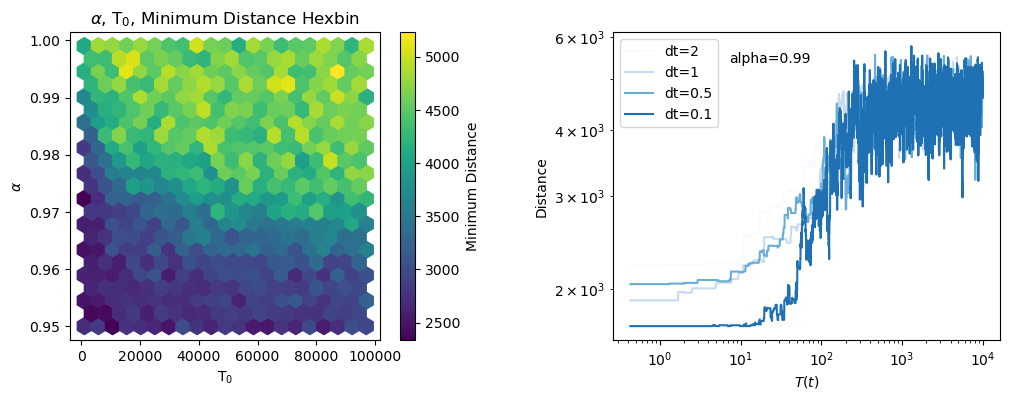

In [16]:
T_0_range = np.arange(1e+3, 1e+5, 3000) ; alpha_range = np.linspace(0.95, 0.999, 50) ; timesteps = [2, 1, 0.5, 0.1] #parameters being tested

# Generate parameter combinations
T_0_values, alpha_values = np.meshgrid(T_0_range, alpha_range)
T_0_values = T_0_values.flatten() ; alpha_values = alpha_values.flatten()

# Iterate Simulated Annealing for each parameter pair
old_distance_values = []
for T_0, alpha in zip(T_0_values, alpha_values):
    old_distance, _, _, _ = annealing(fixed_first_path, T_0=T_0, alpha=alpha, time=200)
    old_distance_values.append(old_distance)


# Hexbin Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  #Figure with two subplots
ax1 = axs[0]
hexbin = ax1.hexbin(T_0_values, alpha_values, C=old_distance_values, gridsize=20, cmap='viridis')
ax1.set_xlabel('T$_0$')  # T with a subscript of 0
ax1.set_ylabel('$\\alpha$')  # Greek letter alpha
ax1.set_title('$\\alpha$, T$_0$, Minimum Distance Hexbin')  #NOTE: overflow error will occur since for low alpha T will get really small for the same time. 
fig.colorbar(hexbin, ax=ax1, label='Minimum Distance')



# Second, line subplot
ax2 = axs[1]
for i in range(4):
    final_distance, path1, solution_space, cooling_schedule = annealing(fixed_first_path, time=1000, T_0=1e+4, alpha=0.99, dt=timesteps[i])
    color = plt.cm.Blues(i / 4)  #slightly different shade of blue colour for each line
    ax2.plot(cooling_schedule, solution_space, color=color, label=f'dt={timesteps[i]}')
ax2.set_xlabel('$T(t)$')
ax2.set_ylabel('Distance')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()
ax2.text(0.3, 0.9, 'alpha=0.99', transform=ax2.transAxes)  #adding the label alpha=0.99

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4)
plt.show()

Rigorously testing the inital annealing parameters uncovered more than just the exact values that help minimize path distance, but also flaws in the inital infastructure that ultimately cause inefficient and unscalable code.

From the hexbin plot of alpha $\alpha$ and intial temperature values T<sub>0</sub>, there exists some region in the parameter space that leads to very poor solutions. This region was not obvious to begin with as the extreme sensitivity of such parameters are hidden by the stochatsic nature of the problem. Only with this frequency based approach could we verify that some parameters are better than others.

Our initial suspicion is that this derived from our choice of temperature schedule. To investigate this an additional parameter was introduced that would allow us to fine tune the time dependency of our schedule. The second plot demonstrates how increasing the sensitivity of our time step during annealing, we obtain better quality solutions. Ultimately, this result is from inadvertently slowing the decay rate of our schedule, allowing our algorithm more equally spaced times where it can be explorative of the solution space, and also exloitative of its minimums. 

These results themselves depend on our choice of alpha, and as-such when alpha is closer to 1, time sensitivity decreases and the inverse occurs when alpha is smaller. Using this we can explain the region of poor results in the first plot, where we kept the the time of simulation low, and also kept dt = 1. The region of brighter colour indicates that our algorithm settled in a local minimum, far from the global one. This suggests that our algorithm for all its parameters considered could not explore enough of the conformational space before 'cooling' off and evolving into a greedy algorithm accepting only better solutions and exploiting the current local minimum.

This melting pot of coupled parameters became increasingly confusing and computationally expensive to explore, so for now, we will use the best parameters identified and later expand on how our inital choices could have been better.

## III. Finding the Minimum Path Connecting 30 Cities.

The optimal parameters identified were $\alpha$ = 0.99, time ~ 1000, T<sub>0</sub> = 10000 and dt = 0.1.

Scaling our model with tuned parameters, we minimised the total path length to tour 30 of the US's capital cities.

This was done by iterating the simulated annealing 20 times, with best known parameters, storing each iterations final distance and path achieved, then once finished the minium distance of these was selected and its path stored.

Time to execute: 29.088207960128784


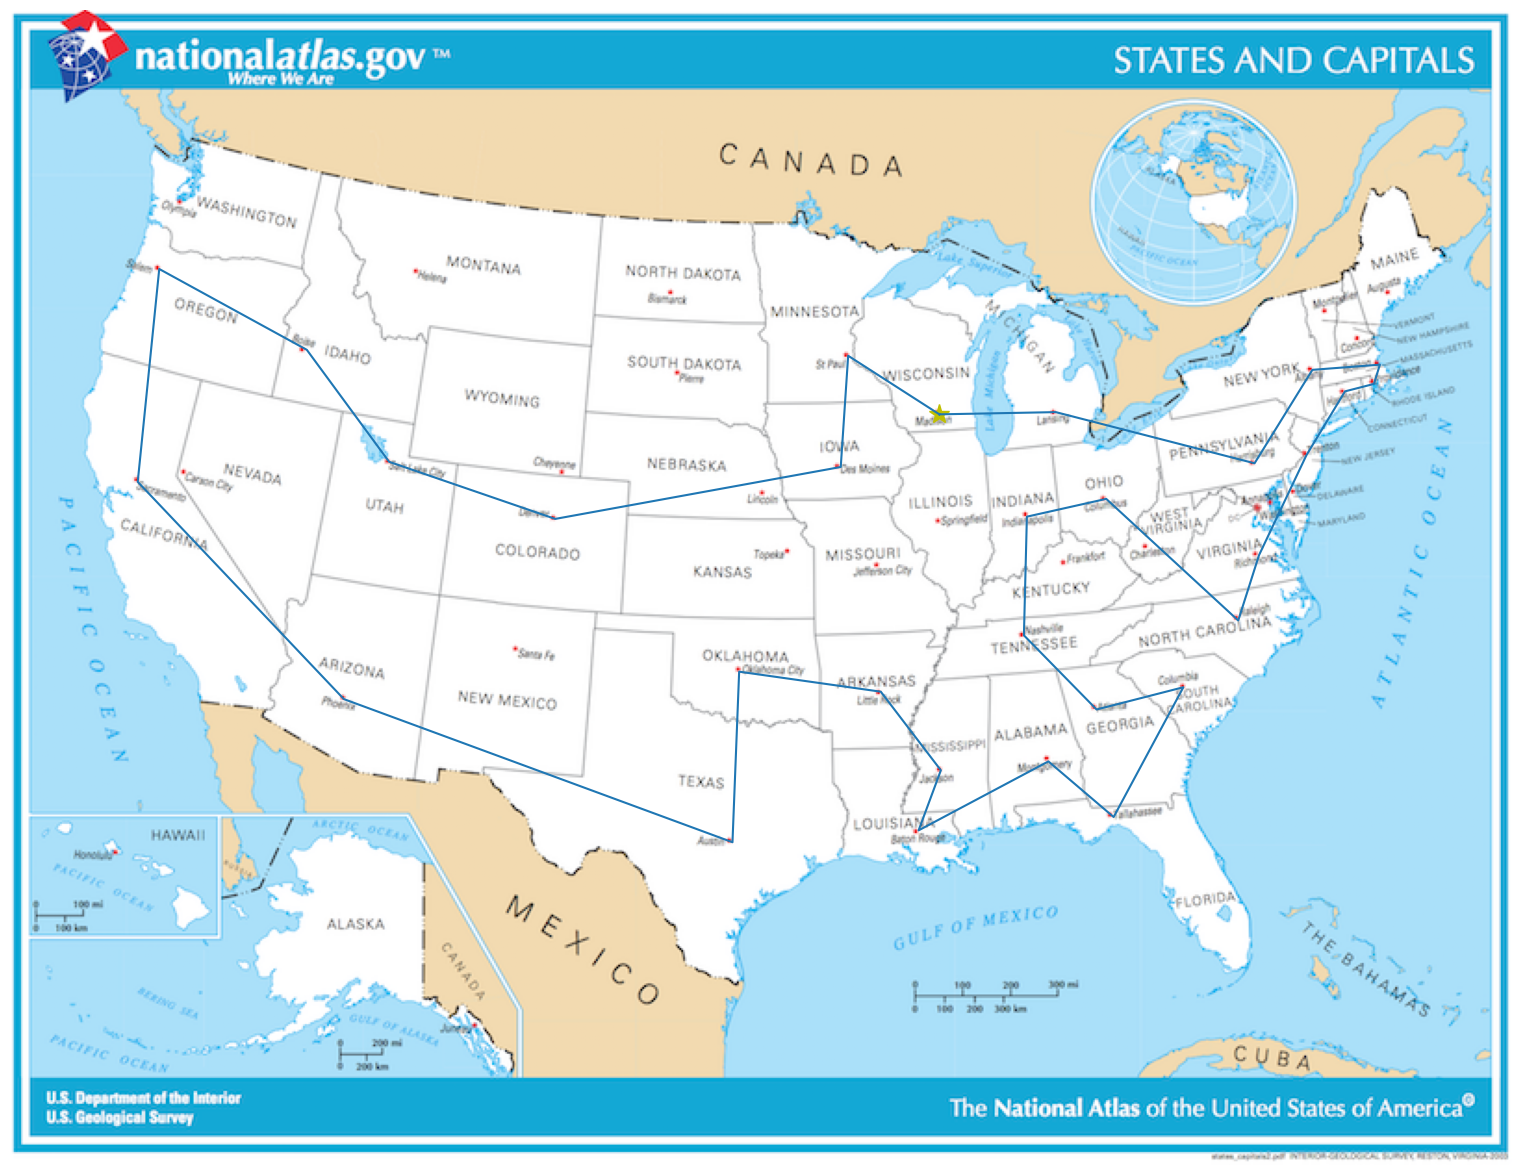

In [17]:
distance_space = [] ; path_space = [] #arrays to store output of each iteration
start=time.time() #starting timer
arbitary_path = random_path(30)

for n in range(20):
    nthdistance, nthpath, _,_= annealing(path = arbitary_path, time = 2000, T_0 = 10000, alpha=0.99, dt = 0.1)
    distance_space.append(nthdistance); path_space.append(nthpath) #saving each iterations output, for conditional selection later.

end=time.time() ; time_taken = end - start 
    
best_path = path_space[distance_space.index(min(distance_space))] 
show_path(best_path , best_path[0]) ; print('Time to execute: {}'.format(time_taken))

Iterated simulated annealing resulted in a final distance and path of;

In [18]:
with open('shortest_path.json', 'r') as file:
    path_best= json.load(file)

original_path = [('Columbus', (590.8, 263.2)),('Atlanta', (585.6, 376.8)),('Hartford', (719.6, 205.2)),('Tallahassee', (594.8, 434.8)),('Richmond', (673.2, 293.6)),('Little Rock', (469.2, 367.2)),('Austin', (389.2, 448.4)),('Jackson', (501.6, 409.6)),('Salem', (80.0, 139.2)),('Indianapolis', (548.0, 272.8)),('Baton Rouge', (489.6, 442.0)),('Boston', (738.4, 190.8)),('Des Moines', (447.6, 246.0)),('Nashville', (546.4, 336.8)),('Madison', (500.8, 217.6)),('Salt Lake City', (204.0, 243.2)),('Montgomery', (559.6, 404.8)),('Sacramento', (68.4, 254.0)),('Providence', (735.2, 201.2)),('Columbia', (632.4, 364.8)),('Boise', (159.6, 182.8)),('Albany', (702.0, 193.6)),('Raleigh', (662.0, 328.8)),('Saint Paul', (451.6, 186.0)),('Oklahoma City', (392.8, 356.4)),('Lansing', (563.6, 216.4)),('Denver', (293.6, 274.0)),('Trenton', (698.8, 239.6)),('Phoenix', (179.6, 371.2)),('Harrisburg', (670.8, 244.0))]

print('Through testing and repeated annealing, we found that one of the shortest tour lengths to travel between a select 30 US capital cities was {} units, this represents a reduction in tour length of {}% from the original route.'.format(length_finder(path_best),(length_finder(original_path)-length_finder(path_best))/(length_finder(original_path))*100 ))

Through testing and repeated annealing, we found that one of the shortest tour lengths to travel between a select 30 US capital cities was 2176.7454864212787 units, this represents a reduction in tour length of 75.81372044449824% from the original route.


To explore how we could re-define our algorithm's objective, we considered the inverse of what we wanted previously. What is the longest path?

## IV. Finding the Longest Path Connecting 30 Cities.

Given our modular approach to the initial problem, this only required a few tweaks.
The original algorithm's objective is principally defined in the definition of the probability (P). If the outcome of the annealing is to be changed, we must change P. Therefore, in the code below the only tweak from the original was to the function P, which was made to be greater than 1 in the case that the new path has a total distance longer than that of the old. This was done by flipping the sign of the exponential term in the original P expression.

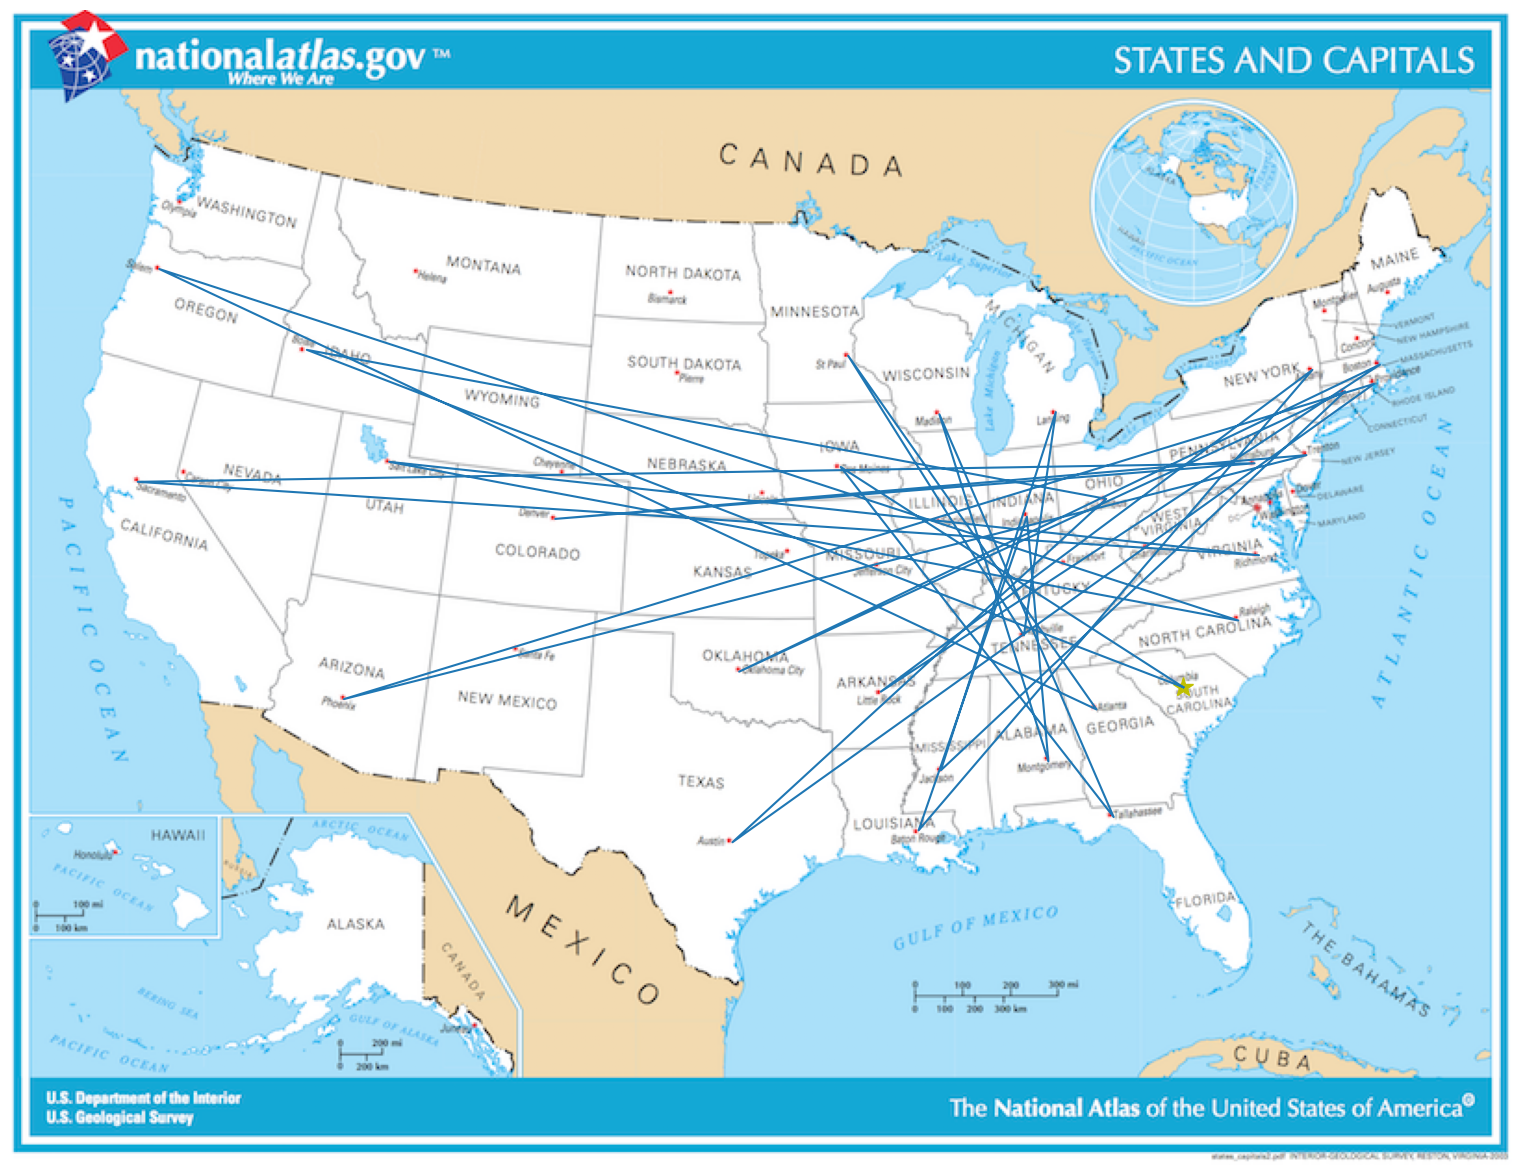

In [19]:
#Specific function, using annealing to find the longest route feasible.

def annealing_inverse(path, T_0 = 1e+3, alpha = 0.97, time = 200):

    old_distance, T = length_finder(path), T_0
    
    #Plotting Purposes
    solution_space = np.zeros(time+1) ; solution_space[0] = old_distance 
    cooling_schedule = [temperature(time, alpha, T_0) for time in range(time+1)]
    
    
    for dt in range(time):
        
        new_path = swap(path) 
        new_distance = length_finder(new_path)
        
        
        P = np.exp((new_distance - old_distance) / T) #Change made to favour longer paths than the current one.
        
        if P >= np.random.random(): #accepted case
            
            path , T, old_distance, solution_space[dt+1] = new_path, temperature(dt, alpha , T_0), new_distance, new_distance
            
        else: T, solution_space[dt+1] = temperature(dt, alpha, T_0), old_distance
            
            
    return old_distance, path, solution_space, cooling_schedule

final,path_longest,sol, cooling = annealing_inverse(random_path(30),alpha=0.999,time=10000)

show_path(path_longest, path_longest[0])

Evidently, this path is purposefully much longer than any random route and reasonably shows us that indeed the minor change made to the original algorithm has had the intended effect.

## V. Introducing Additional Conditions.

To test the versatility of our algorithm, additional conditions were introduced to its objective. Specifically, how might the algorithm find the minimum distance when it should avoid transverse movement through central states.

To do this, a modification was made to the original length calculator function in addition to changing the metric being minimised by simulated annealing. To discourage the annealing process from choosing paths with larger horizontal displacements, a weighting was added to the horizontal component of the pythagorean distance between 2 points. 

This new variable, called 'weighted_distance' was used within the probability function within the simulated annealing the same way distance was originally used. That is, for newer paths with lower distances than old ones the step was accepted. That meant, for a large enough weighting, only paths that more predominantly vertical had the shortest 'weighted_path' and thus were accepted more often than those with predominantly horizontal movement.

In [20]:
def weighted_length_finder(path, weight): #redefining our distance function to include an additional metric dependent on distance.

    consecutives = list(zip(path, path[1:])) #connecting consecutive cities in tuples
    consecutives.append((consecutives[-1][1],consecutives[0][0])) #connecting final city to initial city (making len(consecutives) = len(path)+1)
    
    weighted_distance = 0
    for i in range(len(consecutives)):
        P, Q = coords(consecutives[i])

        weighted_distance += np.sqrt( ((weight*(Q[0] - P[0]))**2) + (Q[1] - P[1])**2) #Weight added to x distance.

    distance = 0
    for i in range(len(consecutives)):
        P, Q = coords(consecutives[i])

        distance += np.sqrt( (Q[0] - P[0])**2 + ((Q[1] - P[1])**2))
    
    
    return weighted_distance, distance 



def transvese_avoidance(path, T_0 = 1e+3, alpha = 0.97, time = 200, weight = 100, dt = 1):
    
    old_weighted_distance, old_distance = weighted_length_finder(path, weight)  #Initial values
    T = T_0
    
    #Required data structures and variables for plotting purposes.
    N = int(time/dt)     #No. of time steps for a given time period.
    times = np.arange(0,time,dt)        #Array storing each time step
    solution_space = np.zeros(N) ; solution_space[0] = old_distance   #Array to track evolution of the minimum tour distance.
    cooling_schedule = [temperature(time, alpha, T_0) for time in times]    #Entire cooling schedule, for each time step.
    
    for k in range(N):
        
        new_path = swap(path) 
        new_weighted_distance, new_distance = weighted_length_finder(new_path, weight)
        
        
        P = np.exp(-(new_weighted_distance - old_weighted_distance) / T)  #Probability based on new and old path length
        
        if P >= np.random.random(): #If probability is greater than a random number between 0-1.
            
            path , T, old_distance, solution_space[k] = new_path, temperature(times[k], alpha , T_0), new_distance, new_distance
            old_weighted_distance = new_weighted_distance
            
        else: T, solution_space[k] = temperature(times[k], alpha, T_0), old_distance
            
            
            
            
    return old_distance, path, solution_space, cooling_schedule

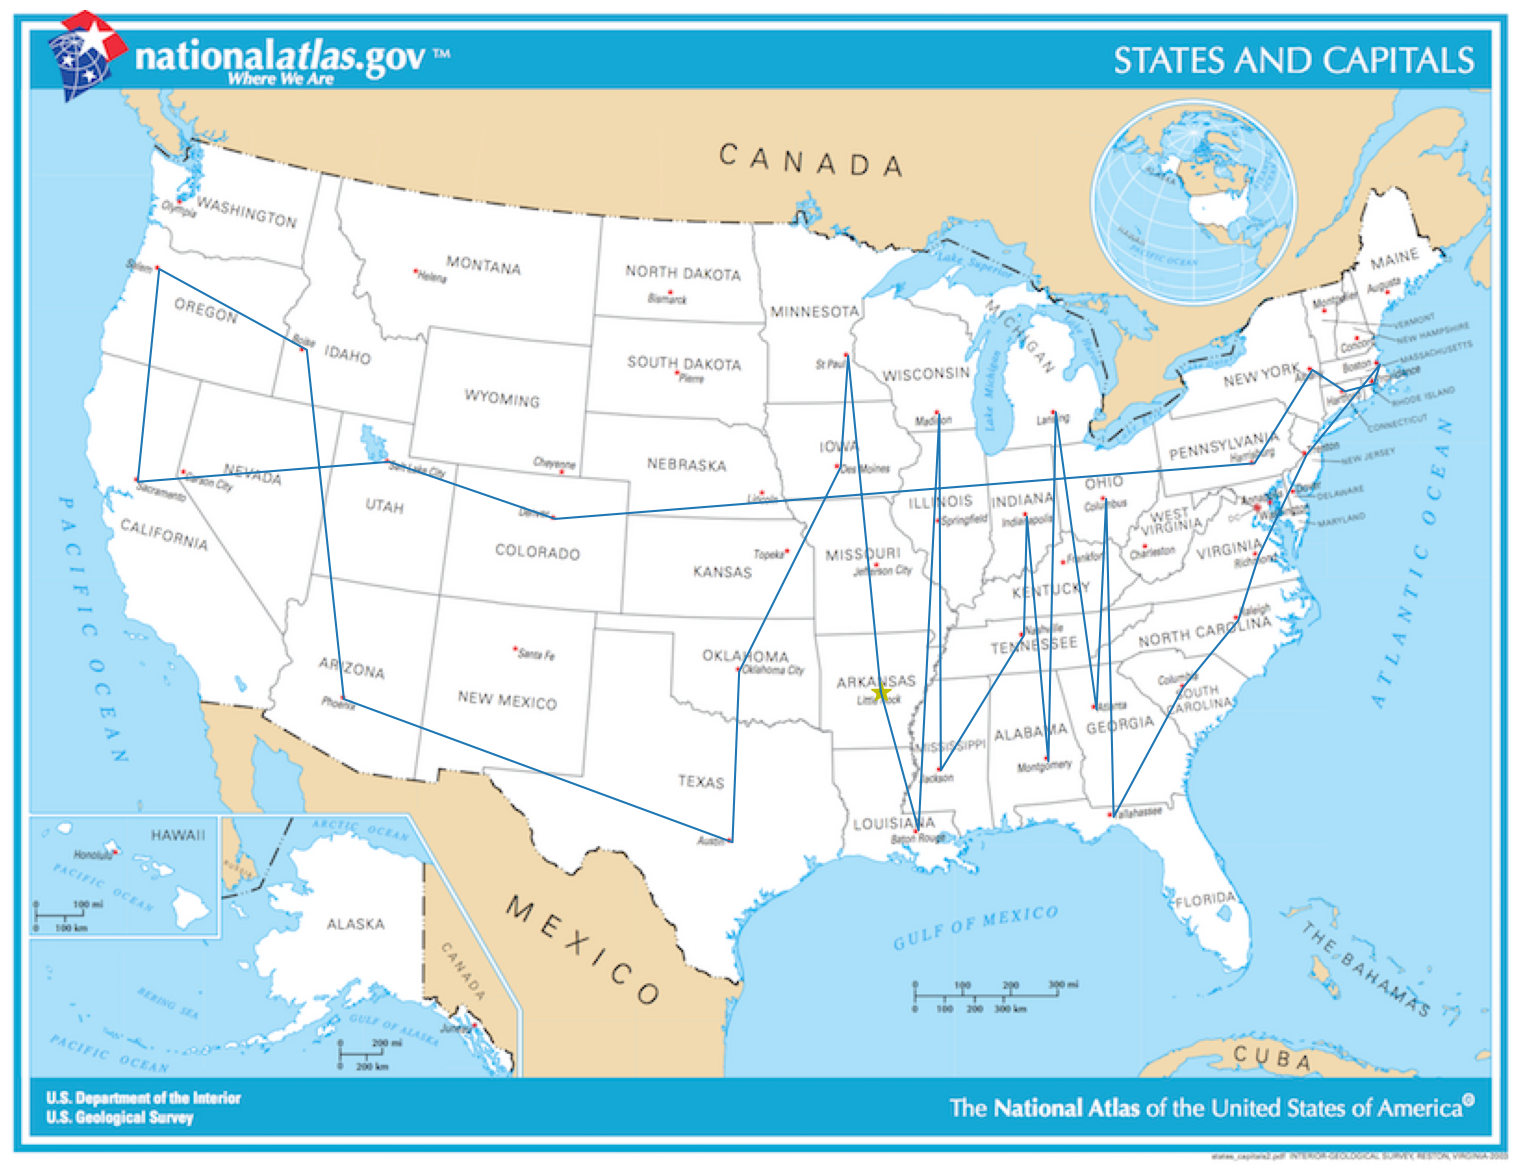

In [21]:
#code that found the new transverse_avoidance function, generating a path favouring vertical movement over horizontal.
#final_distance,path,_,_ = transvese_avoidance(random_path(30),time = 1000, T_0 = 100000, alpha=0.99, weight = 10000, dt=0.1)

with open('Vertical_Path.json','r') as file: #loading previously computed vertically optimised path.
    vertical_path = json.load(file)
show_path(vertical_path,vertical_path[0])

The result above does indeed favour vertical movement over horizontal, all whilst minimizing the total path length to connect 30 cities. This is a good example of the simulated annealing's versatility and adaptability.

## VI. Success and Drawbacks of Simulated Annealing.

Circling back to the successes and pitfalls of our parameter selection, optimisation and underlying forces. One must first recognise, given some work, our annealing algorithm's performace at its objective function. To further the results found previously by the annealing algorithm, when compared with benchmarks including Eli51.TSP and Pr76.TSP [see appendix],[1] which are quite standard extensions of TSP, the results were as follows:


For Euclidean 2D space, connecting well known co-ordinate pairs, our Annealing Achieved Minimum Distance (AAMD):

51 Pairs; AAMD = 519.8 units,   Known Best = 426.0 units,   % Difference = 19.8%, Time = < 30s

76 Pairs; AAMD = 149471.5 units,   Known Best = 108159.0 units,   % Difference = 32.1%, Time = < 50s



Although the AAMD is higher than the Known Best distance of 426.0 units, the resulting percentage difference of 19.8% indicates a significant gap between the achieved solution and the optimal one. The algorithm's execution time was less than 30 seconds, demonstrating a reasonable level of efficiency. Similarly, for 76 points the AAMD does not converge to the known optimal solution.

One significant challenge encountered was the coupled nature of extremely sensitive parameters. The hexbin plot demomstrated that for even minute changes in alpha $\alpha$ and inital temperature T<sub>0</sub> this caused a large change in possible final results. Furthermore, the interdependence of time, $\alpha$ and T<sub>0</sub> made optimizing them for the best annealing results very hard.

The investigation also shed light on the critical role of the cooling schedule. However, determining the optimal cooling schedule proved challenging, and the inadvertent slowing down of the decay rate led to improved solutions.

Generally, the choice of temperature schedule is pivotal in managing the ratio of the algorithms exploration and then eventual exploitation of minima. If the rate of cooling was too fast, like in our case, the algorithm will not explore enough of the solution space, and converge to an incorrect minima. However, if the opposite is true then the algorithm has too little time to exploit its chosen minima and thus misses the opportunity to converge to the correct minimum distance. 


A suggestion that would improve the effectiveness of parameter and schedule optimization would be to experiment with alternative temperature schedules. By changing the form of the schedule, less importance can be put on $\alpha$ or T<sub>0</sub> selection and thus allow researchers to focus more re-iterating the annealing process to obtain better results. In the case of this report, more effective schecules might include;

$$T(t) = \frac{1}{{1 + \alpha t}}$$

$$T(t) = \frac{T_0}{{\alpha t}}$$


Where these examples decay slower but also have the same asymptotes as the original at

$$T(t) = 0$$

On the other hand, implementing a non integer time step also slowed the rate of decay per timestep. Therefore, instead of changing the schedule, one might explore what the effect of changing the swap mechanism defined earlier as a utility function. This might include instead of swapping 2 cities, swapping 3, which has the effect of increasing the rate of exploration possible in a given timestep.

Finally, in this specific use-case, simulated annealing has proved itself as an extremely powerful tool at solving combinatorial optimization problems and therefore could lend itself to other problems in this field. Ironically, simulated annealing could be used to optimise parameter selection for other processes like machine learning [1]. Of course, as previously mentioned it could also provide invaluable in protein folding [2].

## Appendices

 - Benchmark Data for Pr76.TSP and Eli51.TSP     

In [22]:
with open('eli51_TSP.json', 'r') as file:
    eli51_data = json.load(file)

with open('pr76_TSP.json','r') as file:
    pr76_data = json.load(file)

## References

[1] : Joris Kinable (jkinable), coin-or/jorlib, (24-Jul-2016), jorlib-core/src/test/resources/tspLib/tsp, GitHub, ver1.1.1, https://github.com/coin-or/jorlib/tree/b3a41ce773e9b3b5b73c149d4c06097ea1511680/jorlib-core/src/test/resources/tspLib/tsp, date accessed 15/1/2024.

[2] : Lin, S.-W. et al. (2008) ‘Parameter determination of support vector machine and feature selection using simulated annealing approach’, Applied Soft Computing, 8(4), pp. 1505–1512. doi: 10.1016/j.asoc.2007.10.012.

[3] : Agostini FP, Soares-Pinto Dde O, Moret MA, Osthoff C, Pascutti PG. Generalized simulated annealing applied to protein folding studies. J Comput Chem. 2006 Aug;27(11):1142-55. doi: 10.1002/jcc.20428. PMID: 16732545.
